In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import Sequential,backend,optimizers
from keras.layers import Dense,Input, Activation, Flatten, Convolution2D, Dropout,Reshape,LSTM,concatenate,SeparableConv2D
from keras.models import Model
import pickle
import pandas as pd
import os
import re

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


list1=[]
#list1=os.listdir('no_eog')
print(list1)
list2=os.listdir('yes_arousal_old')
print(list2)

for i in list2:
    if(re.search("cnn",i)):
        with open("sample/"+i,"rb") as f:
            cnn_dataset = pickle.load(f)
            print(cnn_dataset.shape)
            if(i=='s01.mat_win_128_cnn_dataset.pkl'):
                cnn_datasets=cnn_dataset
                print(1)
            else:
                cnn_datasets=np.concatenate((cnn_datasets,cnn_dataset),axis=0)
                #cnn_datasets=np.append(cnn_datasets, cnn_dataset, axis=0)
    elif(re.search("rnn",i)):
        with open("sample/"+i,"rb") as f:
            rnn_dataset = pickle.load(f)
            print(rnn_dataset.shape)
            if(i=='s01.mat_win_128_rnn_dataset.pkl'):
                rnn_datasets=rnn_dataset
                print(1)
            else:
                rnn_datasets=np.concatenate((rnn_datasets,cnn_dataset),axis=0)
                #rnn_datasets=np.append(rnn_datasets, rnn_dataset, axis=0)
    elif(re.search("labels",i)):
        with open("sample/"+i,"rb") as f:
            label = pickle.load(f) 
            print(label.shape)
            if(i=='s01.mat_win_128_labels.pkl'):
                print(label.shape)
                labels=label
                print(1)
            else:
                labels=np.concatenate((labels,label),axis=0)
                #labels=np.append(labels, label, axis=0)
for i in list1:
    with open('no_eog/'+i,"rb") as f:
        eog=pickle.load(f)
        eog=np.reshape(eog,(-1,128,2))
        print(eog.shape)
        if(i=='AFT_PREPROCESS_1_DATASET.pkl'):
            eog_dataset=eog
            print(1)
        else:
            eog_datasets=np.concatenate((eog_datasets,eog),axis=0)
            eog_dataset=np.append(eog_dataset,eog,axis=0)

In [2]:
L=2
cnn_datasets=np.empty(shape=[0,128,9,9])
rnn_datasets=np.empty(shape=[0,128,32])
labels=np.empty(shape=[0,])
eog_datasets=np.empty(shape=[0,128,2])
for i in range(1,L+1):
    with open('../preprocessed_data/s0'+str(L)+'.mat_win_128_cnn_dataset.pkl',"rb") as f:
        cnn_dataset = pickle.load(f)
    with open('../preprocessed_data/s0'+str(L)+'.mat_win_128_labels.pkl',"rb") as f:
        label = pickle.load(f)   
    with open('../preprocessed_data/s0'+str(L)+'.mat_win_128_rnn_dataset.pkl',"rb") as f:
        rnn_dataset = pickle.load(f) 
    with open('../preprocessed_data/AFT_PREPROCESS_'+str(L)+'_DATASET.pkl',"rb") as f:
        eog = pickle.load(f) 
        eog=np.reshape(eog,(-1,128,2))
    cnn_datasets=np.concatenate((cnn_datasets,cnn_dataset),axis=0)
    rnn_datasets=np.concatenate((rnn_datasets,rnn_dataset),axis=0)
    labels=np.concatenate((labels,label),axis=0)
    eog_datasets=np.concatenate((eog_datasets,eog),axis=0)

with open('D:\learn\human-machine interaction\yes_arousal_old/s01.mat_win_128_cnn_dataset.pkl',"rb") as f:
    cnn_datasets = pickle.load(f)
with open('D:\learn\human-machine interaction\yes_arousal_old/s01.mat_win_128_labels.pkl',"rb") as f:
    labels = pickle.load(f)   
with open('D:\learn\human-machine interaction\yes_arousal_old/s01.mat_win_128_rnn_dataset.pkl',"rb") as f:
    rnn_datasets = pickle.load(f) 

In [19]:
print(cnn_datasets.shape)
print(labels.shape)
print(rnn_datasets.shape)
print(eog_datasets.shape)
lstm_datasets=rnn_datasets
lstm_datasets=np.concatenate((rnn_datasets,eog_datasets),axis=2)
print(lstm_datasets.shape)

(4800, 128, 9, 9)
(4800,)
(4800, 128, 32)
(4800, 128, 2)
(4800, 128, 34)


In [20]:
cnn_datasets=np.transpose(cnn_datasets, [0,2,3,1])
#cnn_datasets = cnn_datasets.transpose(0,2,3,1)
lstm_datasets=np.transpose(lstm_datasets, [0,2,1])

In [21]:
print(cnn_datasets.shape)
print(labels.shape)
print(lstm_datasets.shape)

(4800, 9, 9, 128)
(4800,)
(4800, 34, 128)


## shuffle data

In [22]:
permutation = np.random.permutation(labels.shape[0])
#shuffled_dataset = labels[permutation, :]
labels = labels[permutation]
cnn_datasets = cnn_datasets[permutation]
lstm_datasets = lstm_datasets[permutation]
print("labels shape after shuffle: {0}\ncnn_datasets shape after shuffle: {1}\nlstm_datasets shape after shurffle:{2}"\
      .format(labels.shape, cnn_datasets.shape, lstm_datasets.shape))

labels shape after shuffle: (4800,)
cnn_datasets shape after shuffle: (4800, 9, 9, 128)
lstm_datasets shape after shurffle:(4800, 34, 128)


In [23]:
one_hot_labels = np.array(list(pd.get_dummies(labels)))
labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

In [24]:
L=cnn_datasets.shape[0]
print(type(L))
L=int(0.8*L)
cnn_train=cnn_datasets[:L,:,:,:]
cnn_test=cnn_datasets[L:,:,:,:]
lstm_train=lstm_datasets[:L,:,:]
lstm_test=lstm_datasets[L:,:,:]
labels_train=labels[:L,]
labels_test=labels[L:,]
print(cnn_train.shape)
print(lstm_train.shape)
print(labels_train.shape)

<class 'int'>
(3840, 9, 9, 128)
(3840, 34, 128)
(3840, 2)


In [25]:
cnn_input=Input(shape=(9,9,128), name='cnn_input') #cnn_input
cnn_1=SeparableConv2D(32,(4,4),strides=(1,1),
               activation='elu'
               ,padding='SAME'
               )(cnn_input)
cnn_2=Convolution2D(64,(4,4),strides=(1,1),
               activation='elu'
               ,padding='SAME'
               )(cnn_1)
cnn_3=Convolution2D(128,(4,4),strides=(1,1),
               activation='elu'
               ,padding='SAME'
               )(cnn_2)
cnn_4=Convolution2D(13,(1,1),strides=(1,1),
               activation='elu',padding='SAME'
                )(cnn_3)
cnn_output=Flatten()(cnn_4)
lstm_input=Input(shape=(34,128),name='lstm_input') #lstm_input
dense=Dense(1024,input_shape=(34,128))(lstm_input)
lstm_1=LSTM(32,input_shape=(32, 1024),return_sequences=True)(dense)
lstm_2=LSTM(32)(lstm_1)
x = concatenate([cnn_output,lstm_2],axis=-1)
#output_2=Flatten()(output_1)
output=Dense(2,activation='softmax')(x) #output
model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
#print(type(model))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 9, 9, 128)    0                                            
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 9, 9, 32)     6176        cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 9, 9, 64)     32832       separable_conv2d_2[0][0]         
__________________________________________________________________________________________________
lstm_input (InputLayer)         (None, 34, 128)      0                                            
__________________________________________________________________________________________________
conv2d_5 (

In [26]:
optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history = model.fit([cnn_train,lstm_train],[labels_train],epochs=5,steps_per_epoch = 5,validation_data=([cnn_test,lstm_test],[labels_test]),
                    validation_steps=5
                )
model.save('my_model.h5')           

Train on 3840 samples, validate on 960 samples
Epoch 1/5
5/5 [==============================] - 101s 20s/step - loss: 0.5899 - acc: 0.6736 - val_loss: 0.4951 - val_acc: 0.7760
Epoch 2/5
5/5 [==============================] - 99s 20s/step - loss: 0.4243 - acc: 0.8309 - val_loss: 0.3723 - val_acc: 0.8573
Epoch 3/5
5/5 [==============================] - 99s 20s/step - loss: 0.2967 - acc: 0.8895 - val_loss: 0.2721 - val_acc: 0.8906
Epoch 4/5
5/5 [==============================] - 97s 19s/step - loss: 0.1989 - acc: 0.9285 - val_loss: 0.2209 - val_acc: 0.9115
Epoch 5/5
5/5 [==============================] - 96s 19s/step - loss: 0.1320 - acc: 0.9537 - val_loss: 0.1797 - val_acc: 0.9323


In [1]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

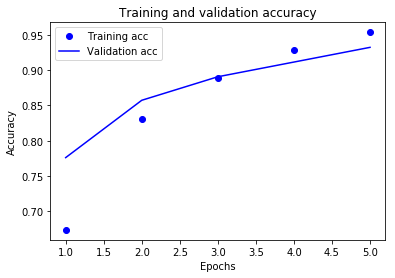

In [29]:
plt.clf()   # clear figure


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()